## Business Object
* Build Predictive maintenance models to predict the probability of device failure based on a year’s worth of data.
* Which can help determine wheather or not a maintenance should be performed to the in-service equipment . 

## Data exploration

### Import moduels

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#from sklearn.naive_bayes import GaussianNB
#from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import GradientBoostingClassifier
#from xgboost import XGBClassifier
#xgb=XGBClassifier()
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
import xgboost as xgb

### Import data as a dataframe

In [2]:
df = pd.read_csv('failures_prediction.csv')

In [3]:
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


### Check the data infos

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
date          124494 non-null object
device        124494 non-null object
failure       124494 non-null int64
attribute1    124494 non-null int64
attribute2    124494 non-null int64
attribute3    124494 non-null int64
attribute4    124494 non-null int64
attribute5    124494 non-null int64
attribute6    124494 non-null int64
attribute7    124494 non-null int64
attribute8    124494 non-null int64
attribute9    124494 non-null int64
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


In [5]:
#no missing values
df.isnull().sum()

date          0
device        0
failure       0
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute8    0
attribute9    0
dtype: int64

In [6]:
#imbalanced classification problem
df.failure.value_counts()

0    124388
1       106
Name: failure, dtype: int64

In [7]:
#no duplicated observations
df.duplicated().sum()

0

In [8]:
#output number of unique values for each column,
#7 attributes have very high percentage of zero values. 
#These could be error codes or some other indicator, I will change their data types later.
cols = df.columns
for col in cols:
    print(col)
    print(df[col].nunique())

date
304
device
1168
failure
2
attribute1
123878
attribute2
558
attribute3
47
attribute4
115
attribute5
60
attribute6
44838
attribute7
28
attribute8
28
attribute9
65


In [9]:
df.columns

Index(['date', 'device', 'failure', 'attribute1', 'attribute2', 'attribute3',
       'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8',
       'attribute9'],
      dtype='object')

In [10]:
#for col in ['attribute1', 'attribute2', 'attribute3',
#       'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8',
#       'attribute9']:
#sns.lmplot(x='attribute1',y='failure',data=df,logistic=True,y_jitter=.03)

### Data visualization

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


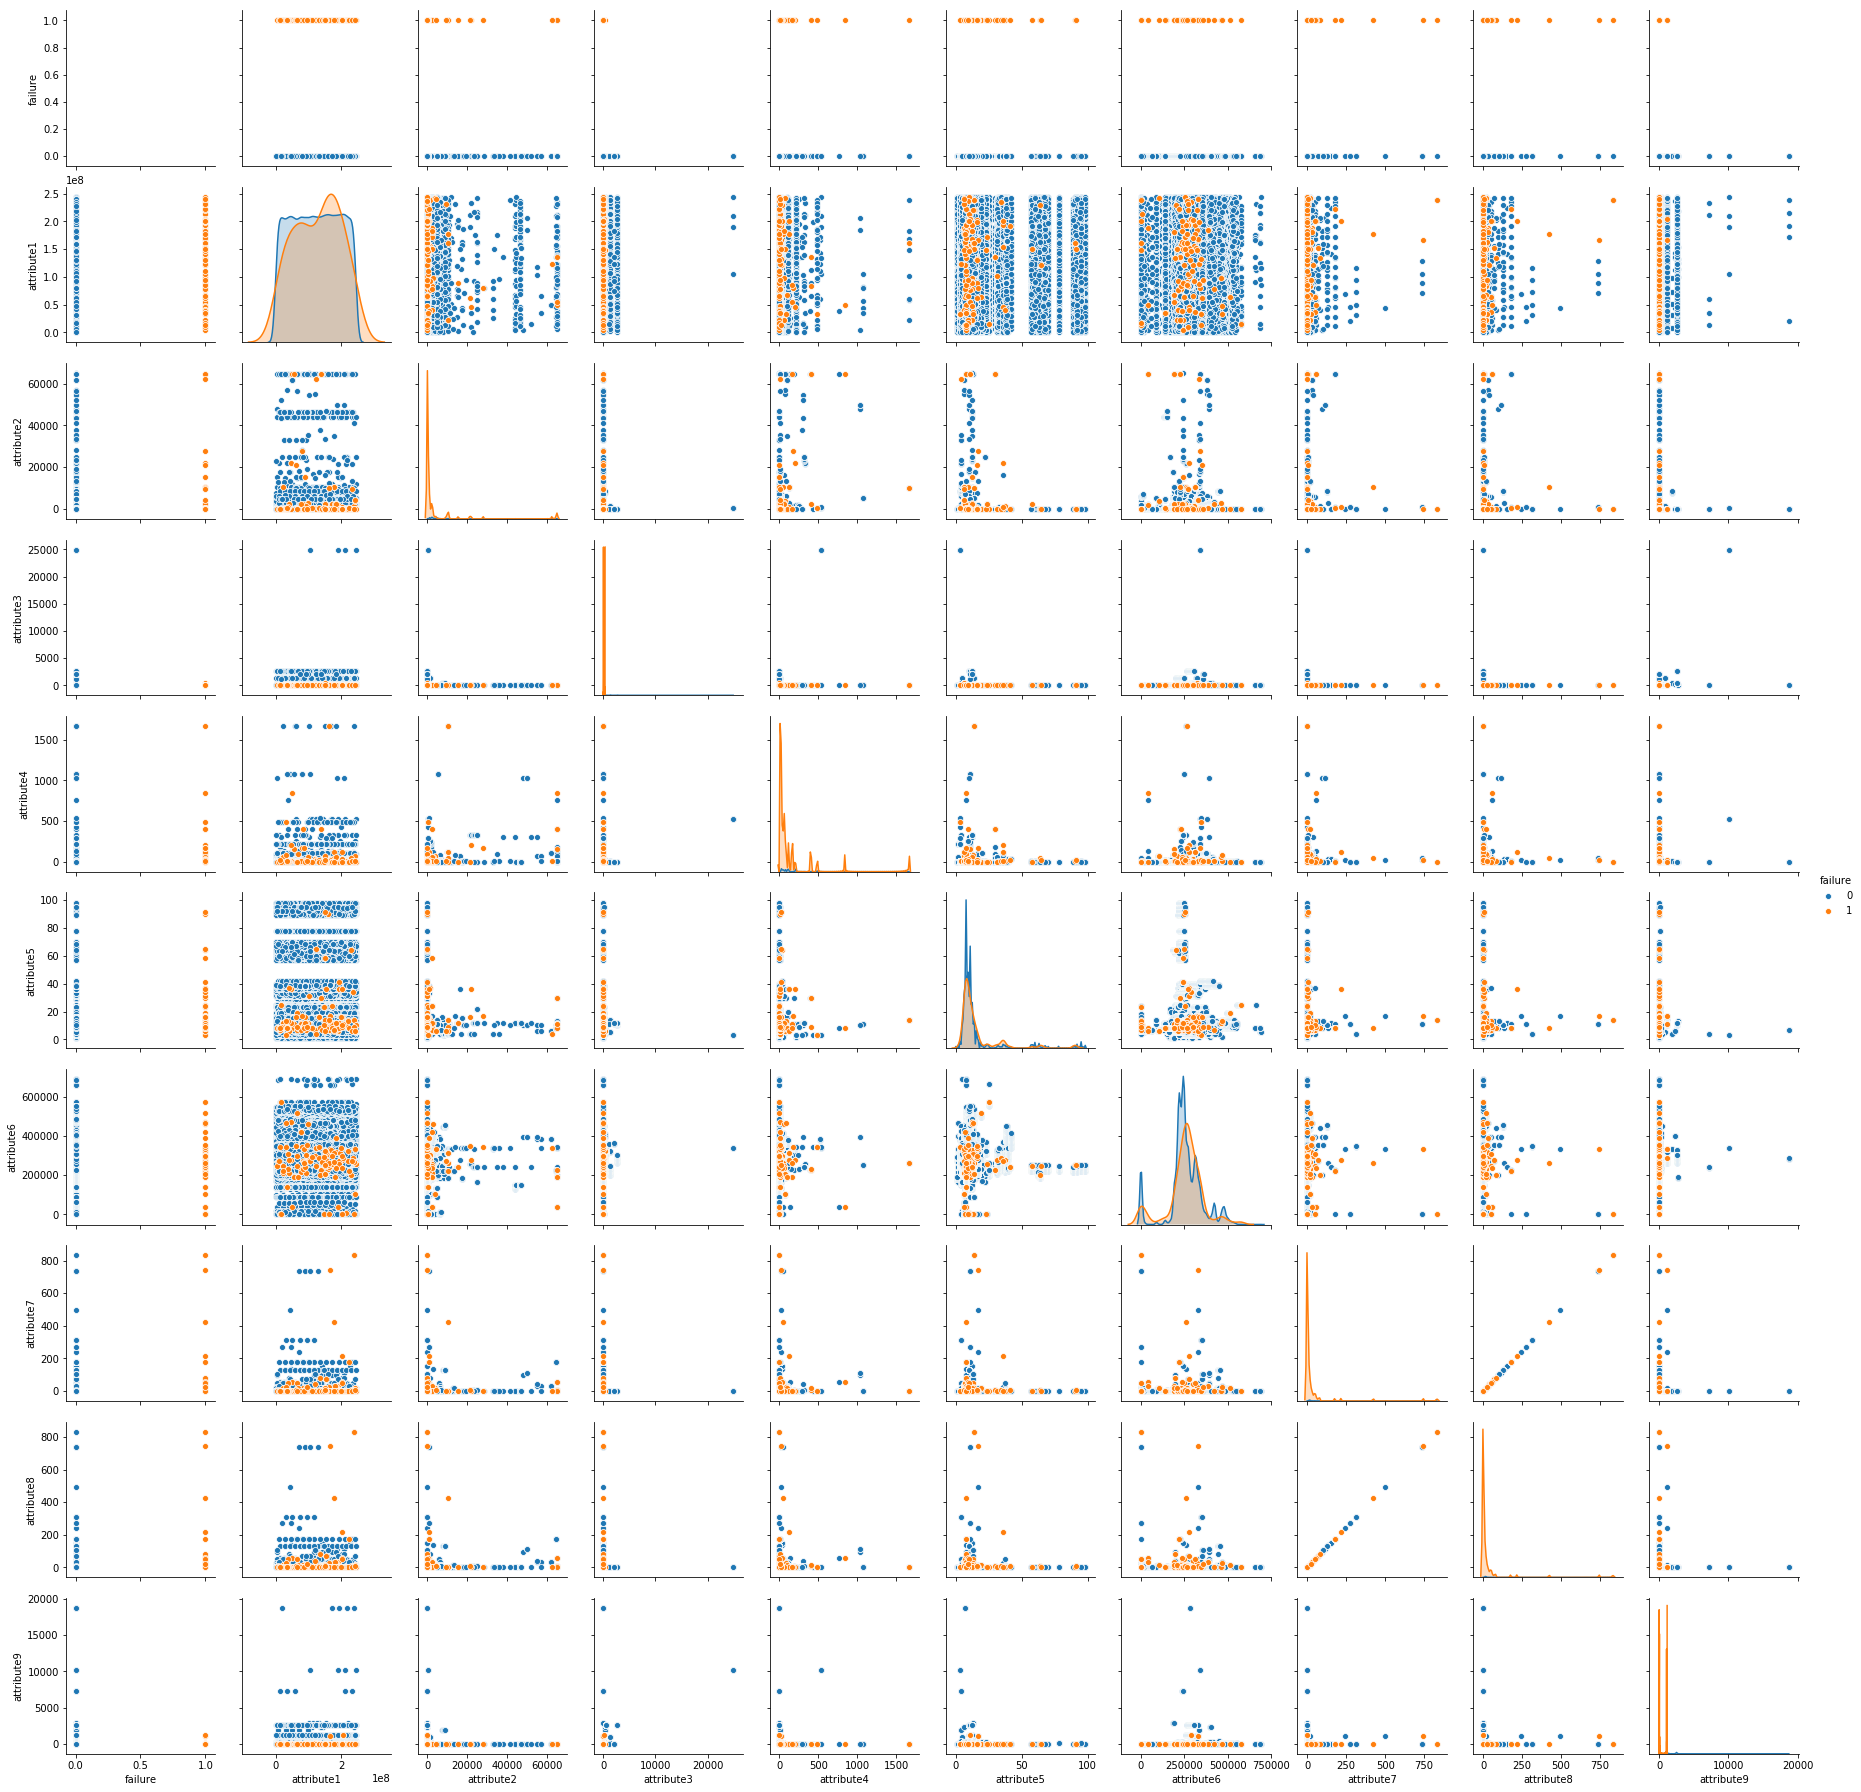

In [11]:
# pair plot to see feature correlations with each other
sns.pairplot(df,hue='failure')

It is obvious that attribute7 and attribut8 is highly linear related or equal to each other

### Summary

* This dataset is clean, no missing values. All attributes are integer data type.
* It is imbalanced data set, as the failuer class is about 0.1% of unfailure class.Here oversampling approach is used to deal with imbalanced dataset.
* Some attributes have limited number of distictive values, very sparse, indicating that they are likely to be categorical variable, such as attibute 3, 5,7,9.
* Attribue7 and 8 seems like exactly same to each other, we can drop one of them.

## Data Processing

### Drop unimportant features

In [12]:
# check if the two features are same
(df['attribute7']==df['attribute8']).value_counts()

True    124494
dtype: int64

In [13]:
# then I drop attribute 8, as it is duplicated.
df.drop('attribute8',axis=1,inplace=True)

In [ ]:
df.drop('date',axis=1,inplace=True)

In [14]:
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,3


### Redefine data types

In [15]:
# redefine data type for some of the numerical features
cat_ftrs = ['attribute3','attribute4', 'attribute5', 'attribute7', 'attribute9']
for col in cat_ftrs:
    df[col]=df[col].astype('object')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 11 columns):
date          124494 non-null object
device        124494 non-null object
failure       124494 non-null int64
attribute1    124494 non-null int64
attribute2    124494 non-null int64
attribute3    124494 non-null object
attribute4    124494 non-null object
attribute5    124494 non-null object
attribute6    124494 non-null int64
attribute7    124494 non-null object
attribute9    124494 non-null object
dtypes: int64(4), object(7)
memory usage: 10.4+ MB


### Create device maintanance times as new feature

In [17]:
# group by device,the size means the mantainance times for each device. sum actually means
# same thing with original failure feature.
check_cnt_df = df.groupby('device').agg({'failure':[np.size,np.sum]})

In [18]:
check_cnt_df.head()

failure    
            size sum
device              
S1F01085       6   0
S1F013BB       6   0
S1F0166B       6   0
S1F01E6Y      48   0
S1F01JE0       6   0

In [19]:
check_cnt_df.columns

MultiIndex(levels=[['failure'], ['size', 'sum']],
           labels=[[0, 0], [0, 1]])

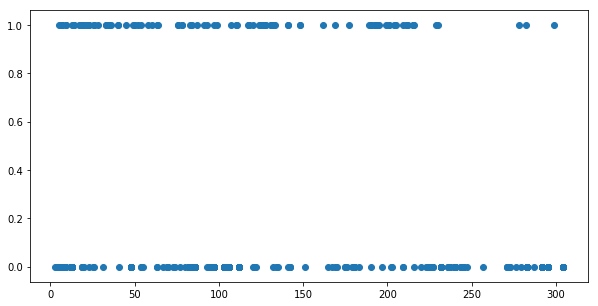

In [20]:
# from this plot, we see that the devices that fail come with 
#less maintanance times(up left scatter), devices not fail come with more maintancance times
#(up right scatter)
plt.figure(figsize=(10,5))
plt.scatter(check_cnt_df[('failure','size')],check_cnt_df[('failure','sum')])

In [21]:
#merge with df
df=df.merge(check_cnt_df,on='device',how='left')

/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [22]:
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,"(failure, size)","(failure, sum)"
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,7,6,0
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,6,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,48,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,6,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,3,223,0


In [23]:
df.shape

(124494, 13)

In [24]:
(df['failure']==df[('failure','sum')]).value_counts()

True     113887
False     10607
dtype: int64

In [25]:
df.drop(('failure','sum'),axis=1,inplace=True)

### Redefine device Id value

In [26]:
#take a look at the device Id, the first four charachers are unique
df.device

0         S1F01085
1         S1F0166B
2         S1F01E6Y
3         S1F01JE0
4         S1F01R2B
5         S1F01TD5
6         S1F01XDJ
7         S1F023H2
8         S1F02A0J
9         S1F02DZ2
10        S1F02EVN
11        S1F02L38
12        S1F02MGA
13        S1F02P76
14        S1F02VAX
15        S1F02WFT
16        S1F0318A
17        S1F0322R
18        S1F0330P
19        S1F035SJ
20        S1F0377V
21        S1F039FE
22        S1F03RV3
23        S1F03YZM
24        S1F044ET
25        S1F049RX
26        S1F04DH8
27        S1F04KSC
28        S1F04MVQ
29        S1F04R7Y
            ...   
124464    S1F0EGMT
124465    S1F0FGBQ
124466    S1F0FP0C
124467    S1F0GCED
124468    S1F0GGPP
124469    S1F0GPXY
124470    S1F0H6JG
124471    S1F0KYCR
124472    S1F0S561
124473    S1F10HH5
124474    S1F10RWZ
124475    W1F05X69
124476    W1F0FEH7
124477    W1F0FY92
124478    W1F0FZPA
124479    W1F0G9T7
124480    W1F0JH87
124481    W1F0JXDL
124482    W1F0JY02
124483    W1F0N84F
124484    W1F0SJJ2
124485    Z1

In [27]:
Id = df.device.values.tolist()

In [28]:
#change device id values to the first four characters
Id1 = []
for i in Id:
    i = i[:4]
    Id1.append(i)

In [29]:
df.device=Id1

In [30]:
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,"(failure, size)"
0,2015-01-01,S1F0,0,215630672,56,0,52,6,407438,0,7,6
1,2015-01-01,S1F0,0,61370680,0,3,0,6,403174,0,0,6
2,2015-01-01,S1F0,0,173295968,0,0,0,12,237394,0,0,48
3,2015-01-01,S1F0,0,79694024,0,0,0,6,410186,0,0,6
4,2015-01-01,S1F0,0,135970480,0,0,0,15,313173,0,3,223


In [31]:
#df.device.hist()

In [32]:
# after redefine the device id, we got 7 unique ids
df.device.value_counts()

S1F0    33169
W1F0    23294
S1F1    21689
W1F1    19974
Z1F0    18869
Z1F1     7248
Z1F2      251
Name: device, dtype: int64

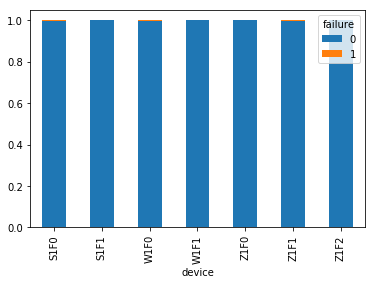

In [33]:
#device id start with S1F0,W1F1 and Z1F1 seem to have bigger chance to fail
dev=pd.crosstab(df['device'],df['failure']) 
dev.div(dev.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True) 
plt.show() 

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124494 entries, 0 to 124493
Data columns (total 12 columns):
date               124494 non-null object
device             124494 non-null object
failure            124494 non-null int64
attribute1         124494 non-null int64
attribute2         124494 non-null int64
attribute3         124494 non-null object
attribute4         124494 non-null object
attribute5         124494 non-null object
attribute6         124494 non-null int64
attribute7         124494 non-null object
attribute9         124494 non-null object
(failure, size)    124494 non-null int64
dtypes: int64(5), object(7)
memory usage: 12.3+ MB


### Extract outliers for numerical features

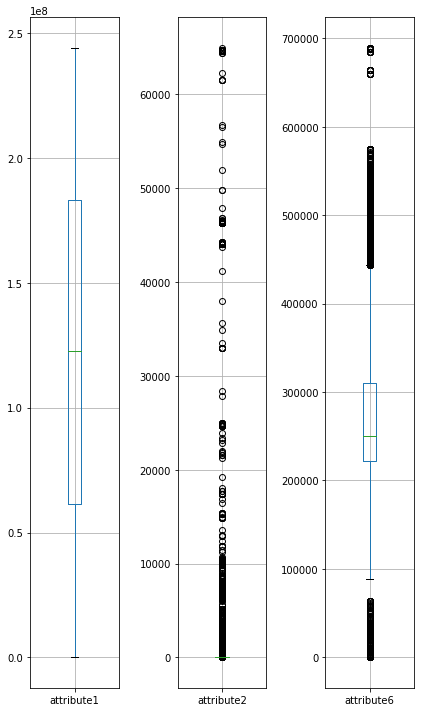

In [35]:
fig = plt.figure(figsize=(6,10))

ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

df.boxplot(column='attribute1', ax=ax1)
df.boxplot(column='attribute2', ax=ax2)
df.boxplot(column='attribute6', ax=ax3)

plt.suptitle('')
plt.tight_layout()

In [36]:
# take 5% of the top values as outliers
outliers = df.quantile(0.95)
outliers

num_ftrs =['attribute1','attribute2','attribute6']

for i in num_ftrs:
    df1=df[(df[i]<outliers[i])]

df1.shape

df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118269 entries, 0 to 124493
Data columns (total 12 columns):
date               118269 non-null object
device             118269 non-null object
failure            118269 non-null int64
attribute1         118269 non-null int64
attribute2         118269 non-null int64
attribute3         118269 non-null object
attribute4         118269 non-null object
attribute5         118269 non-null object
attribute6         118269 non-null int64
attribute7         118269 non-null object
attribute9         118269 non-null object
(failure, size)    118269 non-null int64
dtypes: int64(5), object(7)
memory usage: 11.7+ MB


### Data transformation

* Numerical features normalization

Text(0.5, 1.0, 'Log-Transformed Distribution')

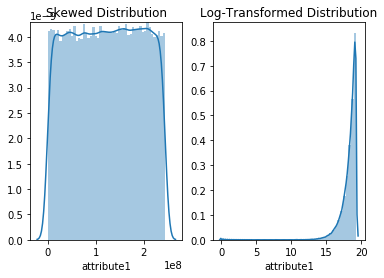

In [37]:
f, axarr = plt.subplots(1,2)
sns.distplot(df1['attribute1'],ax=axarr[0])
axarr[0].set_title('Skewed Distribution')
sns.distplot(np.log(1+df1['attribute1']),ax=axarr[1])
axarr[1].set_title('Log-Transformed Distribution')

Text(0.5, 1.0, 'Log-Transformed Distribution')

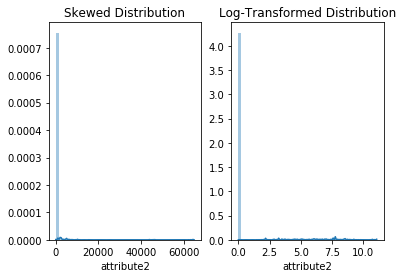

In [38]:
f, axarr = plt.subplots(1,2)
sns.distplot(df1['attribute2'],ax=axarr[0])
axarr[0].set_title('Skewed Distribution')
sns.distplot(np.log(1+df1['attribute2']),ax=axarr[1])
axarr[1].set_title('Log-Transformed Distribution')

Text(0.5, 1.0, 'Log-Transformed Distribution')

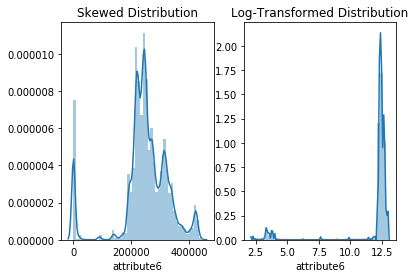

In [39]:
f, axarr = plt.subplots(1,2)
sns.distplot(df1['attribute6'],ax=axarr[0])
axarr[0].set_title('Skewed Distribution')
sns.distplot(np.log(1+df1['attribute6']),ax=axarr[1])
axarr[1].set_title('Log-Transformed Distribution')

* numerical features standardization

In [40]:
df1[num_ftrs]=scaler.fit_transform(df1[num_ftrs])

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [41]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118269 entries, 0 to 124493
Data columns (total 12 columns):
date               118269 non-null object
device             118269 non-null object
failure            118269 non-null int64
attribute1         118269 non-null float64
attribute2         118269 non-null float64
attribute3         118269 non-null object
attribute4         118269 non-null object
attribute5         118269 non-null object
attribute6         118269 non-null float64
attribute7         118269 non-null object
attribute9         118269 non-null object
(failure, size)    118269 non-null int64
dtypes: float64(3), int64(2), object(7)
memory usage: 11.7+ MB


In [43]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118269 entries, 0 to 124493
Data columns (total 11 columns):
device             118269 non-null object
failure            118269 non-null int64
attribute1         118269 non-null float64
attribute2         118269 non-null float64
attribute3         118269 non-null object
attribute4         118269 non-null object
attribute5         118269 non-null object
attribute6         118269 non-null float64
attribute7         118269 non-null object
attribute9         118269 non-null object
(failure, size)    118269 non-null int64
dtypes: float64(3), int64(2), object(6)
memory usage: 10.8+ MB


* get dummies on categorical feature

In [44]:
df1 = pd.get_dummies(df1,drop_first=True)

In [45]:
df1.shape

(118269, 315)

## Feature Selection

### Define dependent and independent values

In [246]:
X = df1.drop('failure',axis=1)
Y = df1['failure']

In [238]:
type(Y)

pandas.core.series.Series

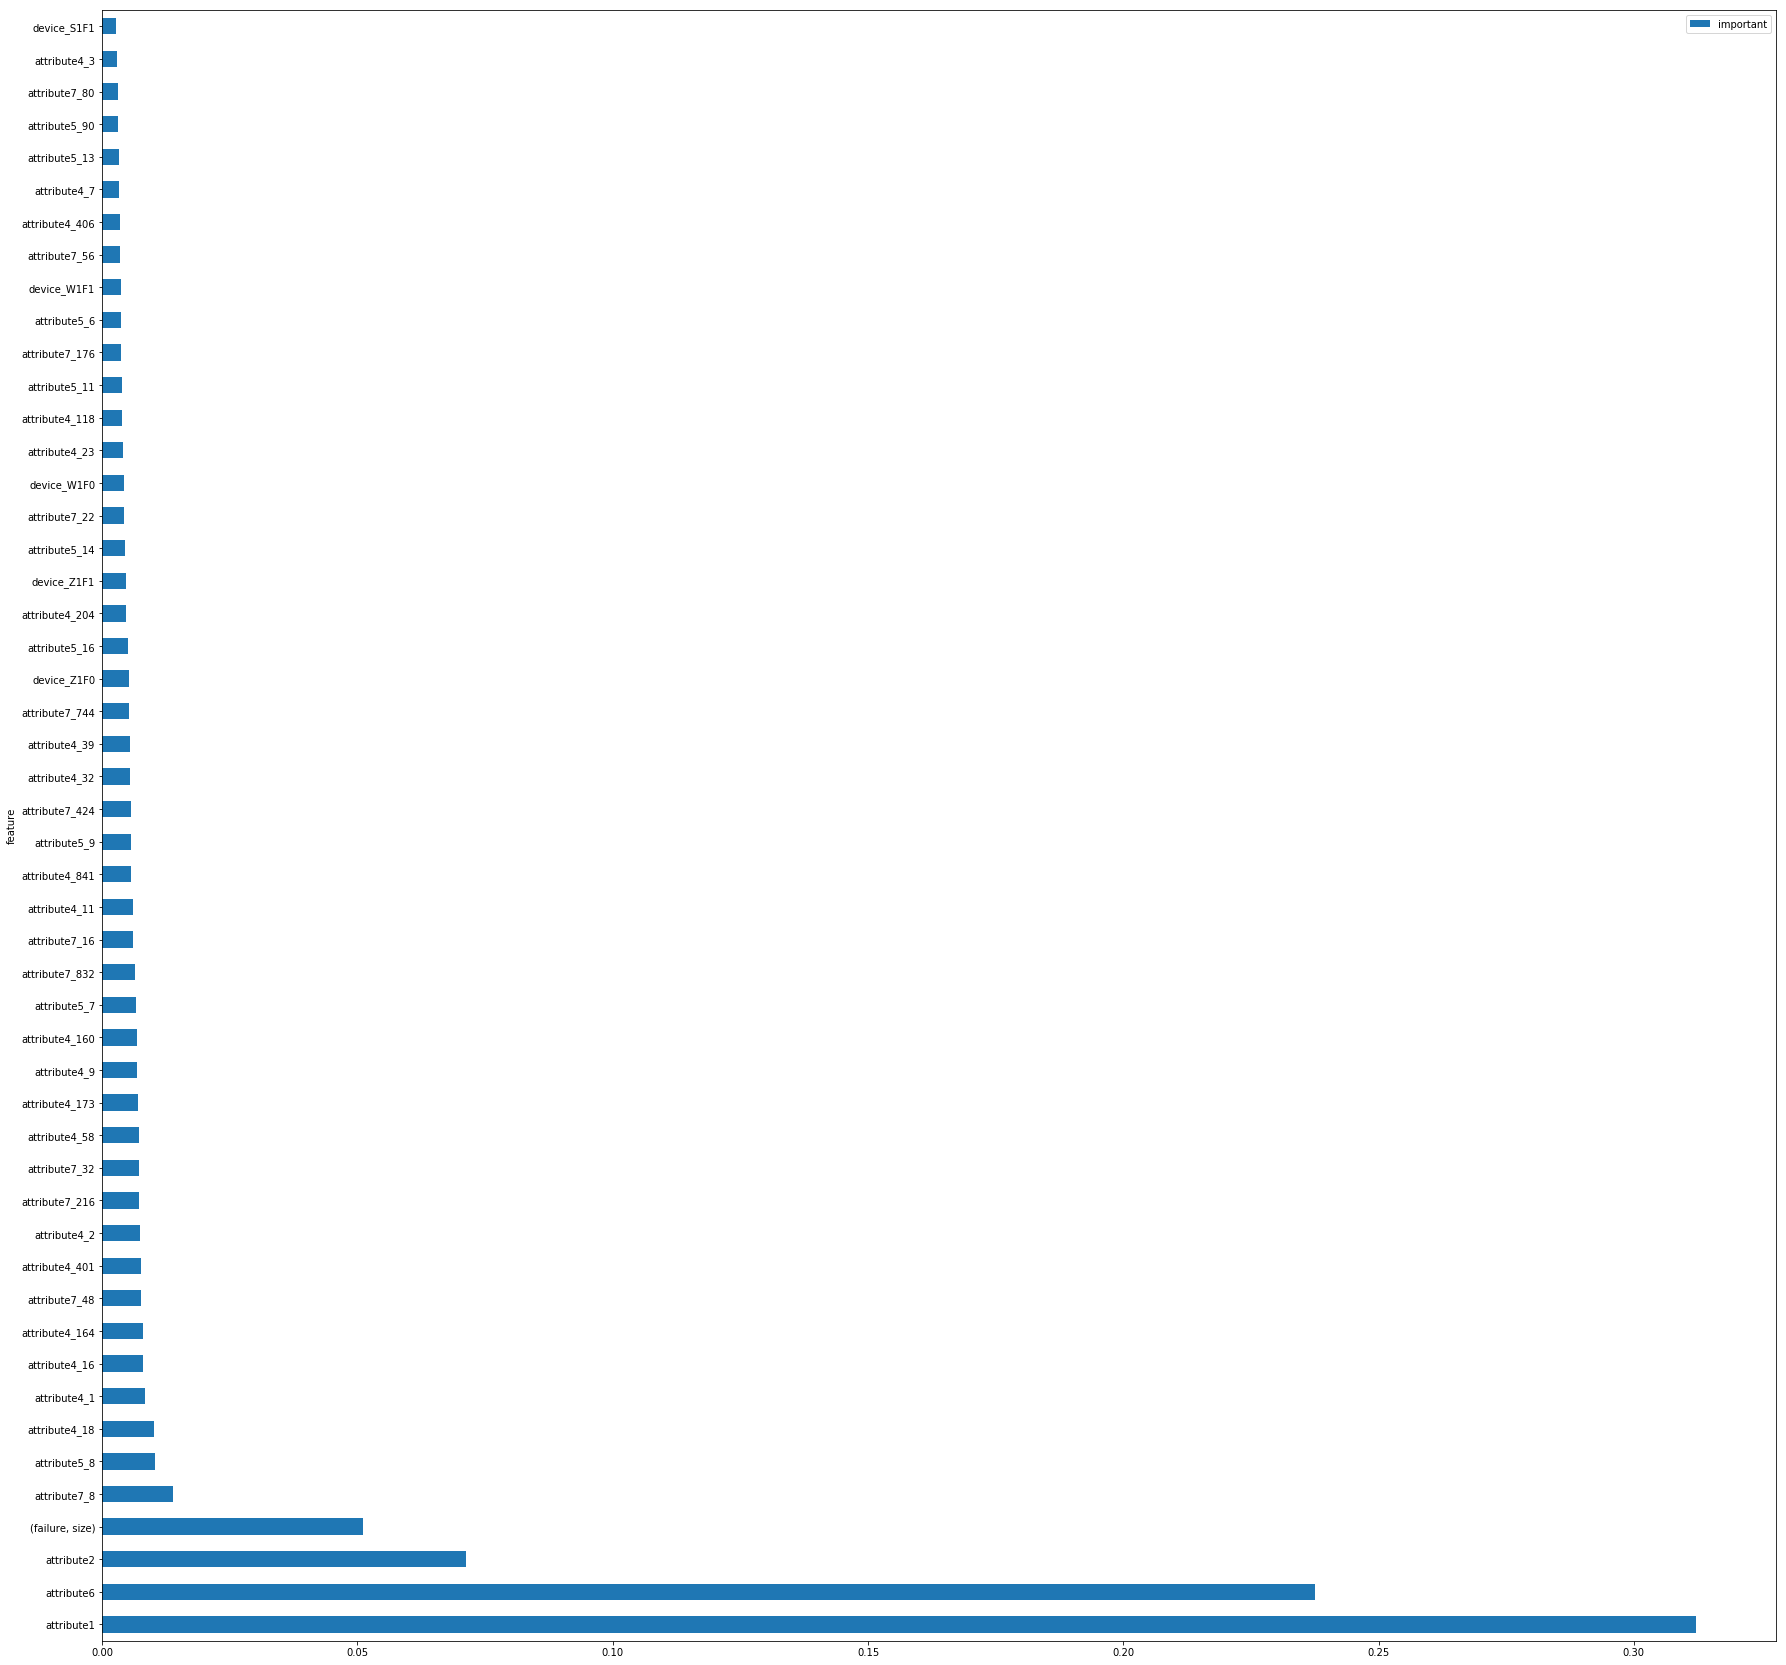

In [175]:
clf = RandomForestClassifier(n_estimators=50, max_features='auto')
clf= clf.fit(X,Y)

features = pd.DataFrame()
features['feature']= X.columns
features['important']=clf.feature_importances_
features.sort_values(by=['important'], ascending=False,inplace=True)
features.set_index('feature', inplace=True)
features.iloc[:50,:].plot(kind='barh', figsize=(30,30))

In [251]:
model = SelectFromModel(clf,prefit=True)
x_reduced = model.transform(X)
print (x_reduced.shape)


(118269, 46)


In [252]:
type(x_reduced)

numpy.ndarray

In [253]:
print(np.any(np.isnan(x_reduced)))

False


In [254]:
print(np.all(np.isfinite(x_reduced)))

True


In [255]:
Y = Y.as_matrix().astype(np.float)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [256]:
x_reduced

array([[ 1.32397975, -0.04943664,  1.83595429, ...,  0.        ,
         0.        ,  0.        ],
       [-0.86624495, -0.07451142,  1.78675012, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.72290028, -0.07451142, -0.12625834, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.46742176,  2.08908367,  1.17788307, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.48474299, -0.07451142,  1.27677608, ...,  0.        ,
         0.        ,  0.        ],
       [-1.48809842, -0.07451142,  1.18966484, ...,  0.        ,
         0.        ,  0.        ]])

In [257]:
Y

array([0., 0., 0., ..., 0., 0., 0.])

### Resample data set
when encounter with imbalanced dataset, we always re-sample the data in order to mitigate the effect caused by class imbalance. The two most common techniques are over-sampling and under-sampling. Here I used under-sampling as the dataset is little big.

In [258]:
# import model for imbalanced data set
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import geometric_mean_score, make_index_balanced_accuracy, classification_report_imbalanced
from sklearn.metrics import confusion_matrix

In [259]:
# tested on RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(x_reduced, Y, train_size=0.8, \
                                                    random_state=42)


rus = RandomUnderSampler(random_state=42)


X_res, y_res = rus.fit_sample(X_train, y_train)
X_res.shape
X_res = pd.DataFrame(X_res)


rf = RandomForestClassifier(n_estimators=5000, random_state=21)

a = rf.fit(X_res,y_res)



rf_test_pred = rf.predict(X_test)
rf_test_cm = confusion_matrix(y_test, rf_test_pred)
rf_test_cm

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


array([[21103,  2533],
       [    4,    14]])

In [260]:
rf_test_cm

accuracy_score(y_test, rf_test_pred)

print(classification_report_imbalanced(y_test,rf_test_pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       1.00      0.89      0.78      0.94      0.83      0.70     23636
        1.0       0.01      0.78      0.89      0.01      0.83      0.69        18

avg / total       1.00      0.89      0.78      0.94      0.83      0.70     23654



* pre is precision, which is a measure of result relevancy;
* rec is recall, which is the same as sensitivity. Recall is a measure of how many truly relevant results are returned;
* spe is specificity;
* f1 is the harmonic average of the precision and recall;
* geo(Matthews correlation coefficient) is the geometric mean of specificity and sensitivity;
* iba is the index of imbalanced accuracy

## Model Training

In [261]:
log=LogisticRegression()
k=KNeighborsClassifier()
gbc =GradientBoostingClassifier()
rgr = RandomForestRegressor(n_estimators=100)
svc = SVC()
rfc = RandomForestClassifier(n_estimators=10)
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
algorithms=[k,log,gbc,rgr,svc,rfc,xg_reg]
names=['KNeighborsClassifier','Logistic','GradientBoost','RandomForest','SVC','RandomForestCl','xgboost']

In [262]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
#import xgboost as xgb

In [263]:
#ni
#ni
#ni

In [264]:
type(x_reduced),type(Y)

(numpy.ndarray, numpy.ndarray)

In [266]:
from sklearn.model_selection import KFold
j=1
kf = KFold(n_splits=5,random_state=1,shuffle=False)
accuracy = []
for train_index,test_index in kf.split(x_reduced,Y,):
            print('\n{} of kfold {}'.format(j,kf.n_splits))
            xtr,xvl = x_reduced[train_index],x_reduced[test_index]     
            ytr,yvl = Y[train_index],Y[test_index]         
            model = GradientBoostingClassifier(random_state=1)     
            model.fit(xtr, ytr)     
            pred_test = model.predict(xvl)     
            score = accuracy_score(yvl,pred_test)
            accuracy.append(score)
            print('accuracy_score',score)
            j=j+1
print(np.mean(accuracy))


1 of kfold 5
accuracy_score 0.9986048871226854

2 of kfold 5
accuracy_score 0.9994081339308363

3 of kfold 5
accuracy_score 0.9994926862264311

4 of kfold 5
accuracy_score 0.9986894394182803

5 of kfold 5
accuracy_score 0.9990276074916501
0.9990445508379766


In [ ]:
def cross_validation_fit_predict(x_reduced,Y,algorithms = algorithms, names = names):
    # fit the data
    # print metrics
    Geo_score = []
    Iba_score = []
    Accuracy = []
    F1=[]
    for i in range(len(algorithms)):
        j=1
        kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 
        geo_score = []
        iba_score = []
        accuracy = []
        f1=[]
        for train_index,test_index in kf.split(x_reduced,Y,):
            '\n{} of kfold {}'.format(j,kf.n_splits)
            xtr,xvl = x_reduced[train_index],x_reduced[test_index]     
            ytr,yvl = Y[train_index],Y[test_index]
            X_res, y_res = rus.fit_sample(xtr, ytr)
            algorithms[i] = algorithms[i].fit(X_res, y_res)  
            pred_test = algorithms[i].predict(xvl)     
            accuracy.append(accuracy_score(yvl, algorithms[i].predict(xvl).round()))
            geo_score.append(geo(yvl, algorithms[i].predict(xvl).round()))
            iba_score.append(iba(yvl, algorithms[i].predict(xvl).round()))
            f1.append(f1_score(yvl, algorithms[i].predict(xvl).round(),average='macro'))
            j+=1
        mean_ac = np.mean(accuracy)
        mean_f1 = np.mean(f1)
        mean_geo=np.mean(geo_score)
        mean_iba=np.mean(iba_score)
        F1.append(mean_f1)
        Geo_score.append(mean_geo)
        Iba_score.append(mean_iba)
        Accuracy.append(mean_ac)
    metrics = pd.DataFrame(columns = ['Accuracy', 'F1','Geo','Iba'], index = names)
    metrics['F1'] = F1
    metrics['Accuracy'] = Accuracy
    metrics['Geo']=Geo_score
    metrics['Iba']=Iba_score
    return metrics.sort_values('Geo', ascending = False)

In [273]:
from sklearn.model_selection import StratifiedKFold

def cross_validation_fit_predict(X_res, y_res, algorithms = algorithms, names = names):
    # fit the data
    # print metrics
    Geo_score = []
    Iba_score = []
    Accuracy = []
    F1=[]
    for i in range(len(algorithms)):
        j=1
        kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 
        geo_score = []
        iba_score = []
        accuracy = []
        f1=[]
        for train_index,test_index in kf.split(X_res, y_res):
            '\n{} of kfold {}'.format(j,kf.n_splits)
            xtr,xvl = x_reduced[train_index],x_reduced[test_index]     
            ytr,yvl = Y[train_index],Y[test_index]
            algorithms[i] = algorithms[i].fit(xtr, ytr)  
            pred_test = algorithms[i].predict(xvl)     
            accuracy.append(accuracy_score(yvl, algorithms[i].predict(xvl).round()))
            geo_score.append(geo(yvl, algorithms[i].predict(xvl).round()))
            iba_score.append(iba(yvl, algorithms[i].predict(xvl).round()))
            f1.append(f1_score(yvl, algorithms[i].predict(xvl).round(),average='macro'))
            j+=1
        mean_ac = np.mean(accuracy)
        mean_f1 = np.mean(f1)
        mean_geo=np.mean(geo_score)
        mean_iba=np.mean(iba_score)
        F1.append(mean_f1)
        Geo_score.append(mean_geo)
        Iba_score.append(mean_iba)
        Accuracy.append(mean_ac)
    metrics = pd.DataFrame(columns = ['Accuracy', 'F1','Geo','Iba'], index = names)
    metrics['F1'] = F1
    metrics['Accuracy'] = Accuracy
    metrics['Geo']=Geo_score
    metrics['Iba']=Iba_score
    return metrics.sort_values('Geo', ascending = False)

In [274]:
cross_validation_fit_predict(X_res, y_res, algorithms = algorithms, names = names)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

,Accuracy,F1,Geo,Iba
SVC,0.808208,0.450807,0.843481,0.712265
KNeighborsClassifier,0.842884,0.461796,0.835771,0.700850
GradientBoost,0.857655,0.466506,0.833363,0.696747
xgboost,0.868909,0.470093,0.833222,0.696577
RandomForest,0.858602,0.466675,0.823827,0.681106
RandomForestCl,0.871935,0.470424,0.782045,0.612327
Logistic,0.801469,0.447791,0.762840,0.588403


In [133]:
from imblearn.metrics import geometric_mean_score as geo
from imblearn.metrics import make_index_balanced_accuracy as iba
iba = make_index_balanced_accuracy(alpha=0.1, squared=True)(geo)

here is the link, why I choose geo and iba
https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/evaluation/plot_metrics.html#sphx-glr-auto-examples-evaluation-plot-metrics-py

In [59]:
#def imblearn_metrics(X_res, y_res, X_test, y_test, algorithms = algorithms, names = names):
#    # fit the data
#    #x_train_reduced, x_test_reduced, y_train, y_test = train_test_split(x_reduced,Y,test_size=0.1, random_state=13)
#    geo_score = []
#    iba_score = []
#    accuracy = []
#    f1=[]
#    for i in range(len(algorithms)):
#        algorithms[i] = algorithms[i].fit(X_res, y_res)
#        y_test_pred = algorithms[i].predict(X_test).round()
#        accuracy.append(accuracy_score(y_test, algorithms[i].predict(X_test).round()))
#        geo_score.append(geo(y_test, algorithms[i].predict(X_test).round()))
#        iba_score.append(iba(y_test, algorithms[i].predict(X_test).round()))
#        f1.append(f1_score(y_test, algorithms[i].predict(X_test).round(),average='macro'))
#        #cm=confusion_matrix(y_test,y_test_pred)
#        #print(cm)
#    metrics = pd.DataFrame(columns = ['Accuracy','geo_score','iba_score'],index=names)
#    metrics['Accuracy']=accuracy
#    metrics['geo_score']=geo_score
#    metrics['iba_score']=iba_score
#    metrics['f1']=f1
#    return metrics.sort_values('geo_score',ascending=False)

### Model evaluation

In [60]:
#imblearn_metrics(X_res, y_res, X_test, y_test, algorithms = algorithms, names = names)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


,Accuracy,geo_score,iba_score,f1
RandomForest,0.879006,0.883930,0.781332,0.473309
GradientBoost,0.871311,0.880050,0.774487,0.470792
RandomForestCl,0.897311,0.805080,0.648154,0.478218
Logistic,0.830557,0.803754,0.646020,0.457157
xgboost,0.820369,0.798805,0.638090,0.453902
SVC,0.816014,0.767721,0.589395,0.452282
KNeighborsClassifier,0.848440,0.720140,0.518602,0.462032


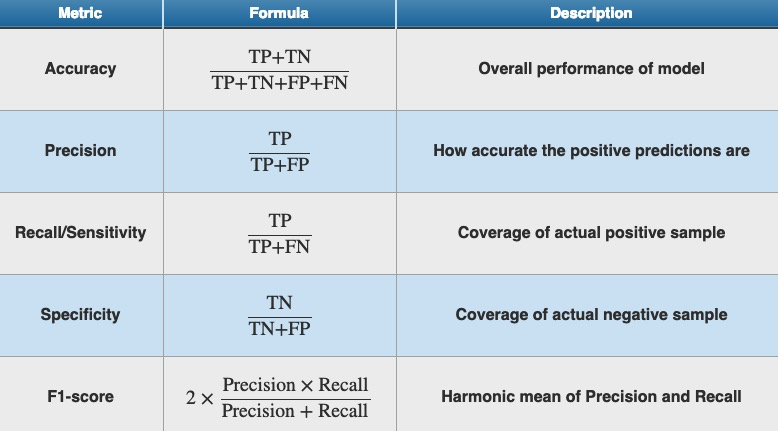

### Model tunning

In [118]:
param_test1 = [i for i in range(5,50,5)]
param_test1

[5, 10, 15, 20, 25, 30, 35, 40, 45]

In [150]:
#tune n_estimators
Geo1=[]
param_test1 = [i for i in range(50,200,30)]
for i in param_test1:
    gbc =GradientBoostingClassifier(n_estimators=i)
    gbc.fit(X_res,y_res)
    y_pred = gbc.predict(X_test).round()
    geo(y_test,y_pred)
    Geo1.append(geo(y_test, y_pred))

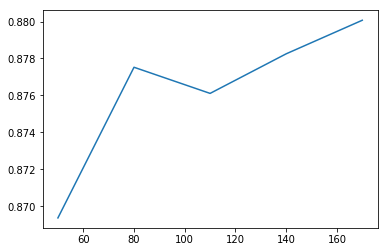

In [151]:
plt.plot(param_test1,Geo1)

In [139]:
#The best n_estimator is 80

In [186]:
#tune learning_rate
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3,\
                max_depth = 5, alpha = 10, n_estimators = 80)
Geo2=[]
Learning_rate = [i for i in np.arange(0.05,0.4,0.03)]
for i in Learning_rate:
    gbc =GradientBoostingClassifier(learning_rate=i)
    gbc.fit(X_res,y_res)
    y_pred = gbc.predict(X_test).round()
    geo(y_test,y_pred)
    Geo2.append(geo(y_test, y_pred))

In [187]:
param_test1
Geo2

[0.8683482564377885,
 0.8705974188690914,
 0.8755295335094699,
 0.8769673089297774,
 0.8806262141787162,
 0.8755724863651638,
 0.8541912171918686,
 0.8506548633970029,
 0.8579595898796931,
 0.8530140615637443,
 0.8528693865749771,
 0.8524765735526271]

In [182]:
Learning_rate

[0.05,
 0.08,
 0.11,
 0.14,
 0.16999999999999998,
 0.2,
 0.22999999999999998,
 0.26,
 0.29,
 0.32,
 0.35,
 0.37999999999999995]

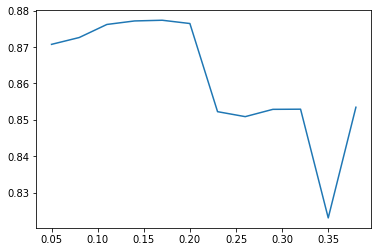

In [183]:
plt.plot(Learning_rate,Geo2)

In [184]:
#best learning_rate is 0.1

### Failure probability prediction

In [203]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3,learning_rate=0.1,\
                max_depth = 5, alpha = 10, n_estimators = 80)

In [205]:
y_pred = xg_reg.predict(X_test).round()
geo(y_test,y_pred)

0.8823753947304406

In [204]:
xg_reg.fit(X_res,y_res)
prob=gbc.predict_proba(X_test)

y_pred_prob = y_test.to_frame()

y_pred_prob['0']=prob[:,0]

y_pred_prob['1']=prob[:,1]

y_pred_prob.head()

,failure,0,1
34643,0,0.990131,0.009869
35832,0,0.977116,0.022884
67849,0,0.999459,0.000541
8409,0,0.966666,0.033334
95115,0,0.999476,0.000524


In [125]:
#param_test1 = {'n_estimators':range(1,50,5)}
##geo = []
##for param_test1 in param_test1:
#
#gsearch1 = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.001, \
#                                        min_samples_split=500,\
#                                        min_samples_leaf=50,\
#                                        max_depth=8,max_features='sqrt',\
#                                        subsample=0.8,random_state=10),\
#                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
#gsearch1.fit(X_res,y_res)
##geo.append(geo(y_test, gsearch1.predict(X_test).round()))
#
#
#                    

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.001, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_...      subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': range(1, 50, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [126]:
#gsearch1.best_params_,gsearch1.best_score_

({'n_estimators': 1}, 0.5)